# Pneumonia Detection from Chest X-ray Images with Deep Learning
Brighton Nkomo

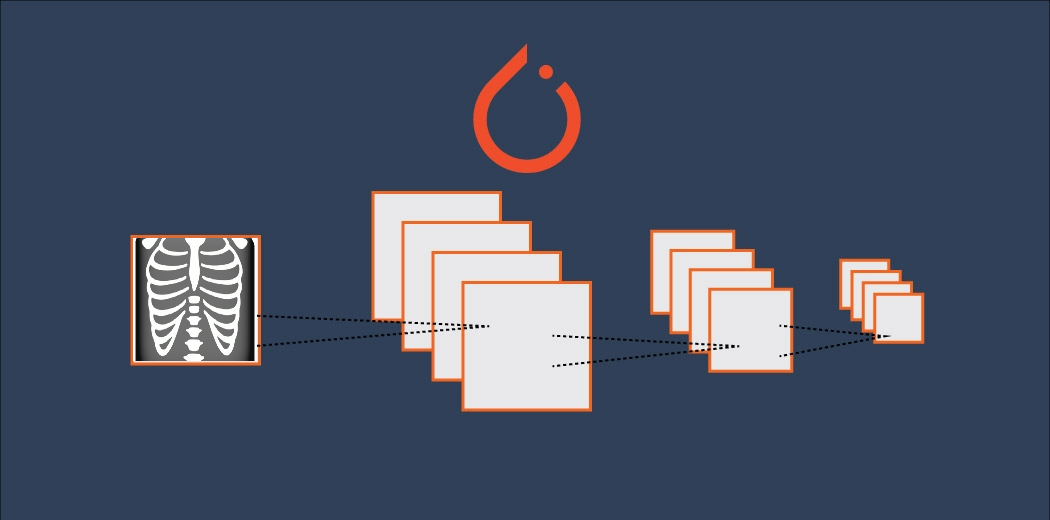

# Description

The data is obtained from [Mendely Data](https://data.mendeley.com/datasets/rscbjbr9sj/2), which is a secure cloud-based repository where you can store your data, ensuring it is easy to share, access and cite, wherever you are. Usually research data is stored there.

I will be looking at a dataset of validated OCT and Chest X-Ray images  described and analyzed in "Deep learning-based classification and referral of treatable human diseases". The OCT Images are split into a training set and a testing set of independent patients. OCT Images are labeled as (disease)-(randomized patient ID)-(image number by this patient) and split into 4 directories: CNV, DME, DRUSEN, and NORMAL.

# Data Preperation

In [1]:
# Import the libraries we need to use in this lab

# Using the following line code to install the torchvision library
# !conda install -y torchvision

# PyTorch Library
import torch
# PyTorch Neural Network
import torch.nn as nn
# Allows us to transform data
import torchvision.transforms as transforms
# Allows us to download the dataset
import torchvision.datasets as dsets
# Used to graph data and loss curves
import matplotlib.pylab as plt
# Allows us to use arrays to manipulate and store data
import numpy as np

import os

Define the function `plot_channels` to plot out the kernel parameters of  each channel

In [2]:
# Define the function for plotting the channels

def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0
    
    #plot outputs as rows inputs as columns 
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()

Define the function `plot_parameters` to plot out the kernel parameters of each channel with Multiple outputs.

In [3]:
# Define the function for plotting the parameters

def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)    
    plt.show()

Define the function `plot_activation` to plot out the activations of the Convolutional layers

In [4]:
# Define the function for plotting the activations

def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.9)    

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the sub-plot.
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

# Loading and Reading the Data

We create a transform to resize the image and convert it to a tensor.

In [6]:
train_composed = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_composed = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

Load the training dataset by setting the parameter `train` to `True`. We use the transform defined above.

In [7]:
trainset = dsets.ImageFolder(os.path.join('chest_xray', 'train'),transform = train_composed)
testset = dsets.ImageFolder(os.path.join('chest_xray', 'test'),transform = test_composed)

In [13]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64)

In [8]:
class_names = trainset.classes
print(class_names)
print(trainset.class_to_idx)

['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


Let's see how much data is in the train and test set.

In [9]:
print('Number of images in the train set:',len(trainset))
print('Number of images in the test set:',len(testset))

Number of images in the train set: 5232
Number of images in the test set: 624


I could say, print out the label for the fourth data element

In [10]:
trainset[3][1]

0

Let's visualise the images (16 of them)

C:\Users\vnbri\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if sys.path[0] == '':


tensor([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0])


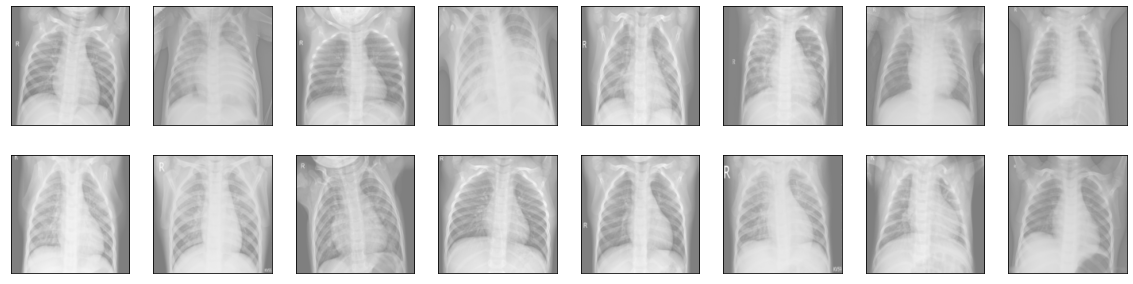

In [17]:
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1,2,0)));
    
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(20,5))

for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[]);
    imshow(images[idx]);
print(labels) 

# Model Building 

In [18]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        # The reason we start with 1 channel is because we have a single black and white image
        # Channel Width after this layer is 16
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        # Channel Wifth after this layer is 8
        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        # Channel Width after this layer is 8
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        # Channel Width after this layer is 4
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        # In total we have out_2 (32) channels which are each 4 * 4 in size based on the width calculation above. Channels are squares.
        # The output is a value for each class
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)
    
    # Prediction
    def forward(self, x):
        # Puts the X value through each cnn, relu, and pooling layer and it is flattened for input into the fully connected layer
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
    # Outputs result of each stage of the CNN, relu, and pooling layers
    def activations(self, x):
        # Outputs activation this is not necessary
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out1,out

# Model Training

# Model Evaluation